# MobileNetV2 Image Classification

## Introduction
In this exercise, the lightweight network MobileNetV2 is used to classify flower image datasets.

## Preparations
Before you start, check whether MindSpore has been correctly installed. You are advised to install MindSpore on your computer by referring to the [MindSpore official website](https://www.mindspore.cn/install/en). In addition, you should have basic mathematical knowledge, including knowledge of Python coding basics, probability, and matrices.

**Recommended environment:**
- Version: MindSpore 1.7
- Programming language: Python 3.7

##  Detailed Design and Implementation

### Data Preparation
The flower image dataset used in this example is an open-source dataset containing five flower types:
- Daisies (633 images)
- Dandelions (898 images)
- Roses (641 images)
- Sunflowers (699 images)
- Tulips (799 images)

The 3670 photos, which are about 230 MB in total, are stored in five folders. To facilitate the model test after deployment, the dataset is divided into `flower_photos_train` and `flower_photos_test`.

The directory structure is as follows:
flower_photos_train<br>
├── daisy<br>
├── dandelion<br>
├── roses<BR>
├── sunflowers<br>
├── tulips<br>
└── LICENSE.txt<br>

flower_photos_test<br>
├── daisy<br>
├── dandelion<br>
├── roses<BR>
├── sunflowers<br>
├── tulips<br>
└── LICENSE.txt<br>

Obtain the datasets from the following links: <br>https://ascend-professional-construction-dataset.obs.myhuaweicloud.com/deeplearning/flower_photos_train.zip <br>https://ascend-professional-construction-dataset.obs.myhuaweicloud.com/deep-learning/flower_photos_test.zip

### Procedure
#### **Step 1: Load the datase**

Define the `create_dataset` function, use the `ImageFolderDataset` API to load the flower image classification dataset, and perform image enhancement on the datade:**


In [1]:
import mindspore.dataset as ds 
import mindspore.dataset.vision as CV 
from mindspore import dtype as mstype 

train_data_path = '../datasets/Flower_Photos/flower_photos_train'
val_data_path = '../datasets/Flower_Photos/flower_photos_test' 

def create_dataset(data_path, batch_size=18, training=True): 
    """Define the dataset. 
        
    Please ensure to set the `num_parallel_workers` parameter in the `create_dataset` function to a value between 1 and the number of CPU cores available on your machine.
    Example: If your machine has 4 CPU cores, set `num_parallel_workers=4`."""
   
    data_set = ds.ImageFolderDataset(data_path, num_parallel_workers=6, shuffle=True, class_indexing={'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}) 
    

    # Perform image enhancement on the dataset. 
    image_size = 224 
    mean = [0.485 * 255, 0.456 * 255, 0.406 * 255] 
    std = [0.229 * 255, 0.224 * 255, 0.225 * 255] 
    
    if training: 
        trans = [ 
            CV.RandomCropDecodeResize(image_size, scale=(0.08, 1.0), ratio=(0.75, 1.333)), 
            CV.RandomHorizontalFlip(prob=0.5), 
            CV.Normalize(mean=mean, std=std), 
            CV.HWC2CHW() ] 
    else: 
        trans = [ 
            CV.Decode(), 
            CV.Resize(256),
            CV.CenterCrop(image_size), 
            CV.HWC2CHW() ] 

    # Perform the data map, batch, and repeat operations. 
    data_set = data_set.map(operations=trans, input_columns="image", num_parallel_workers=6) 

    # Set the value of the batch_size. Discard the samples if the number of samples last fetched is less than the value of batch_size. 
    data_set = data_set.batch(batch_size, drop_remainder=True) 
        
    return data_set 
        

dataset_train = create_dataset(train_data_path) 
dataset_val = create_dataset(val_data_path)

#### Step 2: Visualize the Dataset
The return value of the training dataset loaded from the create_dataset API is a dictionary. You can use the create_dict_iterator API to create a data iterator and use next to iteratively access the dataset.

Here, batch_size is set to 18. Therefore, you can use next to obtain 18 images and label data at a time.

Tensor of image (18, 3, 224, 224)
Labels: [1 4 4 1 2 0 0 3 2 0 2 4 0 2 3 0 3 0]


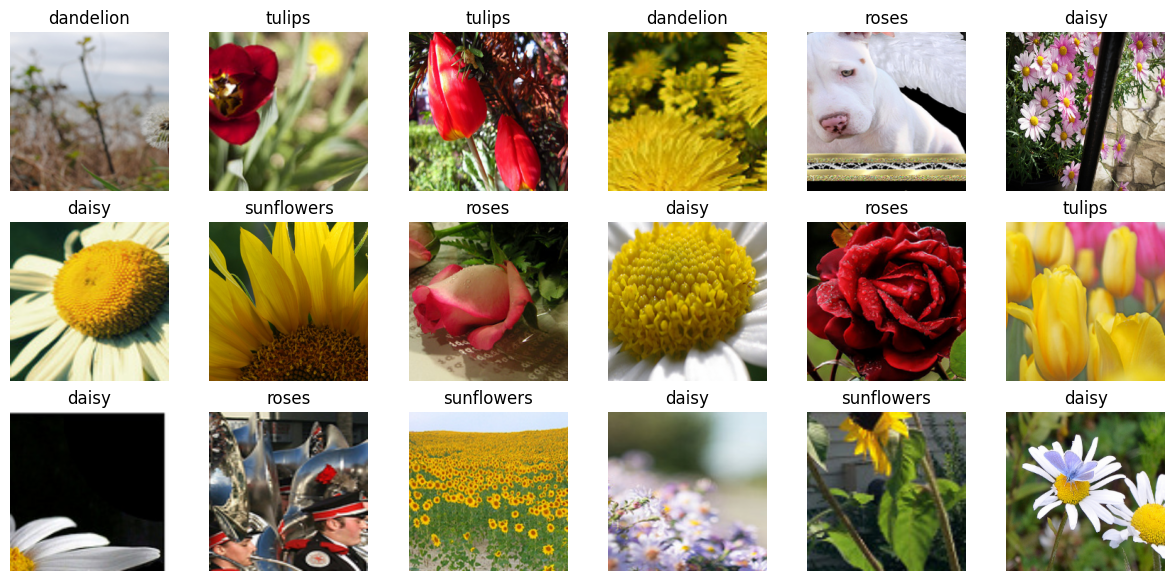

In [2]:
import matplotlib.pyplot as plt 
import numpy as np 

if dataset_train is None:
    raise ValueError("The dataset_train is None. Please check the dataset paths and creation process.")
if dataset_val is None:
    raise ValueError("The dataset_val is None. Please check the dataset paths and creation process.")

data = next(dataset_train.create_dict_iterator()) 
images = data["image"] 
labels = data["label"] 
print("Tensor of image", images.shape) 
print("Labels:", labels) 

# class_name corresponds to label. Labels are marked in ascending order of the folder character string. 
class_name = {0:'daisy',1:'dandelion',2:'roses',3:'sunflowers',4:'tulips'} 
plt.figure(figsize=(15, 7)) 

for i in range(len(labels)): 
    # Obtain an image and its label. 
    data_image = images[i].asnumpy() 
    data_label = labels[i] 

    # Process images for display. 
    data_image = np.transpose(data_image, (1, 2, 0)) 
    mean = np.array([0.485, 0.456, 0.406]) 
    std = np.array([0.229, 0.224, 0.225]) 
    data_image = std * data_image + mean 
    data_image = np.clip(data_image, 0, 1) 

    # Display the image. 
    plt.subplot(3, 6, i + 1) 
    plt.imshow(data_image) 
    plt.title(class_name[int(labels[i].asnumpy())]) 
    plt.axis("off") 
plt.show()

#### Step 3: Create a MobileNetV2 Model

Datasets are crucial for training. A good dataset can effectively improve training accuracy and efficiency. 

MobileNet is a lightweight CNN proposed by Google in 2017 to focus on mobile, embedded, and IoT devices. Compared with traditional convolutional neural networks, MobileNet uses depthwise separable convolution to greatly reduce the model parameters and computation amount with a slight decrease in accuracy. 

In addition, the width coefficient α and resolution coefficient β are introduced to meet the requirements of different application scenarios. Because a large amount of data is lost when the ReLU activation function in the MobileNet processes low-dimensional feature information, the MobileNetV2 proposes to use an inverted residual block and Linear Bottlenecks to design the network, improving the accuracy of the model and making the optimized model smaller. 

![MobileNet Inverted Residual block](mobilenet.png)


In the inverted residual block structure, the 1 x 1 convolution is used for dimension increase, the 3 x 3 depthwise convolution is used, and the 1 x 1 convolution is used for dimension reduction. This structure is opposite to the residual block structure. For the residual block, the 1 x 1 convolution is first used for dimension reduction, then the 3 x 3 convolution is used, and finally the 1 x 1 convolution is used for dimension increase. 

For details, see the MobileNetV2 paper at https://arxiv.org/pdf/1801.04381.pdf.

In [3]:
import numpy as np 
import mindspore as ms 
import mindspore.nn as nn 
import mindspore.ops as ops 

def _make_divisible(v, divisor, min_value=None): 
    if min_value is None:
        min_value = divisor 
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor) 
    # Make sure that round down does not go down by more than 10%. 
    if new_v < 0.9 * v: 
        new_v += divisor 
    return new_v 
    
class GlobalAvgPooling(nn.Cell): 
    def __init__(self): 
        super(GlobalAvgPooling, self).__init__() 
        self.mean = ops.ReduceMean(keep_dims=False) 
        
    def construct(self, x): 
        x = self.mean(x, (2, 3)) 
        return x 
        
class ConvBNReLU(nn.Cell): 
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1): 
        super(ConvBNReLU, self).__init__() 
        padding = (kernel_size - 1) // 2 
        in_channels = in_planes 
        out_channels = out_planes 
        if groups == 1: 
            conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, pad_mode='pad', padding=padding) 
        else: 
            out_channels = in_planes 
            conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, pad_mode='pad', padding=padding, group=in_channels) 
        layers = [conv, nn.BatchNorm2d(out_planes), nn.ReLU6()] 
        self.features = nn.SequentialCell(layers) 
        
    def construct(self, x): 
        output = self.features(x) 
        return output 
            
class InvertedResidual(nn.Cell): 
    def __init__(self, inp, oup, stride, expand_ratio): 
        super(InvertedResidual, self).__init__() 
        assert stride in [1, 2] 
        
        hidden_dim = int(round(inp * expand_ratio)) 
        self.use_res_connect = stride == 1 and inp == oup 
        
        layers = [] 
        if expand_ratio != 1: 
            layers.append(ConvBNReLU(inp, hidden_dim, kernel_size=1)) 
        layers.extend([
            # dw 
            ConvBNReLU(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim), 
            
            # pw-linear 
            nn.Conv2d(hidden_dim, oup, kernel_size=1, stride=1, has_bias=False), nn.BatchNorm2d(oup), ]) 
        
        self.conv = nn.SequentialCell(layers) 
        self.add = ops.Add() 
        self.cast = ops.Cast() 
        
    def construct(self, x): 
        identity = x 
        x = self.conv(x) 
        if self.use_res_connect: 
            return self.add(identity, x) 
        return x 
            
class MobileNetV2Backbone(nn.Cell): 
    def __init__(self, width_mult=1., inverted_residual_setting=None, round_nearest=8, input_channel=32, last_channel=1280): 
        super(MobileNetV2Backbone, self).__init__() 
        block = InvertedResidual 
        
        # setting of inverted residual blocks 
        self.cfgs = inverted_residual_setting 
        if inverted_residual_setting is None: 
            self.cfgs = [ 
                # t, c, n, s 
                [1, 16, 1, 1], 
                [6, 24, 2, 2], 
                [6, 32, 3, 2], 
                [6, 64, 4, 2], 
                [6, 96, 3, 1], 
                [6, 160, 3, 2], 
                [6, 320, 1, 1], 
            ] 

        # building first layer 
        input_channel = _make_divisible(input_channel * width_mult, round_nearest) 
        self.out_channels = _make_divisible(last_channel * max(1.0, width_mult), round_nearest) 
        features = [ConvBNReLU(3, input_channel, stride=2)] 
        
        # building inverted residual blocks 
        for t, c, n, s in self.cfgs: 
            output_channel = _make_divisible(c * width_mult, round_nearest) 
            for i in range(n): 
                stride = s if i == 0 else 1 
                features.append(block(input_channel, output_channel, stride, expand_ratio=t)) 
                input_channel = output_channel 
                
        # building last several layers 
        features.append(ConvBNReLU(input_channel, self.out_channels, kernel_size=1))
        
        # make it nn.CellList 
        self.features = nn.SequentialCell(features)
        self._initialize_weights() 
        
    def construct(self, x): 
        x = self.features(x) 
        return x 
        
    def _initialize_weights(self): 
        self.init_parameters_data() 
        for _, m in self.cells_and_names(): 
            if isinstance(m, nn.Conv2d): 
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels 
                m.weight.set_data(ms.Tensor(np.random.normal(0, np.sqrt(2. / n), 
                                                             m.weight.data.shape).astype("float32"))) 
                
                if m.bias is not None: 
                    m.bias.set_data( 
                        ms.numpy.zeros(m.bias.data.shape, dtype="float32")) 
            elif isinstance(m, nn.BatchNorm2d): 
                m.gamma.set_data( 
                    ms.Tensor(np.ones(m.gamma.data.shape, dtype="float32"))) 
                m.beta.set_data( 
                    ms.numpy.zeros(m.beta.data.shape, dtype="float32")) 
    
    @property 
    def get_features(self): 
        return self.features 
    
class MobileNetV2Head(nn.Cell): 
    
    def __init__(self, input_channel=1280, num_classes=1000, has_dropout=False, activation="None"): 
        super(MobileNetV2Head, self).__init__() 
        
        # mobilenet head 
        head = ([GlobalAvgPooling()] if not has_dropout else 
                [GlobalAvgPooling(), nn.Dropout(0.2)]) 
        self.head = nn.SequentialCell(head) 
        self.dense = nn.Dense(input_channel, num_classes, has_bias=True) 
        self.need_activation = True 
        if activation == "Sigmoid": 
            self.activation = ops.Sigmoid() 
        elif activation == "Softmax": 
            self.activation = ops.Softmax() 
        else: 
            self.need_activation = False 
        self._initialize_weights() 
    
    def construct(self, x): 
        x = self.head(x) 
        x = self.dense(x) 
        if self.need_activation: 
            x = self.activation(x) 
        return x
    
    def _initialize_weights(self): 
        self.init_parameters_data() 
        for _, m in self.cells_and_names(): 
            if isinstance(m, nn.Dense): 
                m.weight.set_data(ms.Tensor(np.random.normal(
                    0, 0.01, m.weight.data.shape).astype("float32"))) 
                if m.bias is not None: 
                    m.bias.set_data( 
                        ms.numpy.zeros(m.bias.data.shape, dtype="float32")) 
                    
class MobileNetV2Combine(nn.Cell): 
    def __init__(self, backbone, head): 
        super(MobileNetV2Combine, self).__init__(auto_prefix=False) 
        self.backbone = backbone 
        self.head = head 
        
    def construct(self, x): 
        x = self.backbone(x) 
        x = self.head(x) 
        return x 

def mobilenet_v2(num_classes): 
    backbone_net = MobileNetV2Backbone() 
    head_net = MobileNetV2Head(backbone_net.out_channels, num_classes) 
    return MobileNetV2Combine(backbone_net, head_net)


#### Step 4: Train and Validate the Model

After a model, a loss function, and an optimizer are created, the Model API is used to initialize the model, the `model.train` API is used to train the model, and the `model.eval` API is used to validate the model accuracy. This section involves the following knowledge of transfer learning:

1. **Download a Pre-trained Model Weight**  
   Download the model file pre-trained on the ImageNet dataset, and save it to the directory at the same level as the running code.  
   Download link: [https://download.mindspore.cn/models/r1.7/mobilenetv2_ascend_v170_imagenet2012_official_cv_top1acc71.88.ckpt](https://download.mindspore.cn/models/r1.7/mobilenetv2_ascend_v170_imagenet2012_official_cv_top1acc71.88.ckpt)

2. **Read the Pre-trained Model**  
   Read the pre-trained model file through the `load_checkpoint()` API. The output result is in dictionary data format.

3. **Modify Pre-trained Model Parameters**  
   Modify the parameters related to the pre-trained model weight. (The model is pre-trained on the ImageNet dataset to classify 1001 types. However, the current exercise is to classify five types of flowers. The network model modifies the last fully-connected layer.)

In [4]:
import mindspore 
import mindspore.nn as nn 
from mindspore.train import Model 
from mindspore import Tensor, save_checkpoint

from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor 
from mindspore.train.serialization import load_checkpoint, load_param_into_net 

# Create a model. The number of target classes is 5. 
network = mobilenet_v2(5) 

# Load the pre-trained weight. 
param_dict = load_checkpoint("./mobilenetv2_ascend_v170_imagenet2012_official_cv_top1acc71.88.ckpt") 

# Modify the weight data based on the modified model structure. 
param_dict["dense.weight"] = mindspore.Parameter(Tensor(param_dict["dense.weight"][:5, :],mindspore.float32), name="dense.weight", requires_grad=True) 
param_dict["dense.bias"] = mindspore.Parameter(Tensor(param_dict["dense.bias"][:5, ],mindspore.float32), name="dense.bias", requires_grad=True) 

# Load the modified weight parameters to the model. 
load_param_into_net(network, param_dict) 

train_step_size = dataset_train.get_dataset_size() 
epoch_size = 20 
lr = nn.cosine_decay_lr(min_lr=0.0, max_lr=0.1,total_step=epoch_size * 
                        train_step_size,step_per_epoch=train_step_size,decay_epoch=200) 

# Define the optimizer. 
network_opt = nn.Momentum(params=network.trainable_params(), learning_rate=0.01, momentum=0.9) 

# Define the loss function. 
network_loss = loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean") 

# Define evaluation metrics. 
metrics = {"Accuracy": nn.Accuracy()} 

# Initialize the model. 
model = Model(network, loss_fn=network_loss, optimizer=network_opt, metrics=metrics) 

# Monitor the loss value. 
loss_cb = LossMonitor(per_print_times=train_step_size) 

# Set the number of steps for saving a model and the maximum number of models that can be saved. 
ckpt_config = CheckpointConfig(save_checkpoint_steps=100, keep_checkpoint_max=10) 

# Save the model. Set the name, path, and parameters for saving the model. 
ckpoint_cb = ModelCheckpoint(prefix="mobilenet_v2", directory='./ckpt', config=ckpt_config) 


print("============== Starting Training ==============") 

# Train a model, set the number of training times to 5, and set the training set and callback function. 
model.train(5, dataset_train, callbacks=[loss_cb,ckpoint_cb], dataset_sink_mode=True) 

# Use the test set to validate the model and output the accuracy of the test set. 
metric = model.eval(dataset_val) 
print(metric)

============== Starting Training ==============
epoch: 1 step: 201, loss is 0.739328145980835
epoch: 2 step: 201, loss is 0.3793027400970459
epoch: 3 step: 201, loss is 0.5879928469657898
epoch: 4 step: 201, loss is 0.19233450293540955
epoch: 5 step: 201, loss is 0.44184547662734985
{'Accuracy': np.float64(0.9166666666666666)}


#### Step 5: Visualize the Model Prediction Result

Define the `visualize_model` function, use the model with the highest validation accuracy described above to predict the input image, and visualize the prediction result.

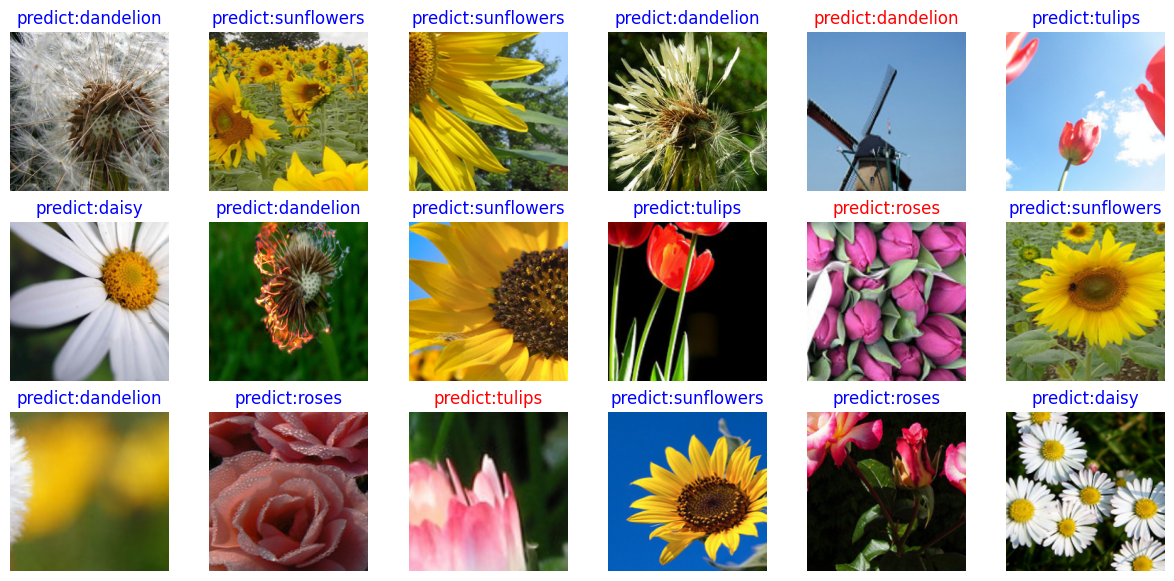

In [5]:
import matplotlib.pyplot as plt 
import mindspore as ms 

def visualize_model(best_ckpt_path, val_ds): 
    num_class = 5 # Perform binary classification on wolf and dog images. 
    net = mobilenet_v2(num_class) 

    # Load model parameters. 
    param_dict = ms.load_checkpoint(best_ckpt_path) 
    ms.load_param_into_net(net, param_dict) 
    model = ms.Model(net) 

    # Load the validation dataset. 
    data = next(val_ds.create_dict_iterator()) 
    images = data["image"].asnumpy() 
    labels = data["label"].asnumpy() 
    class_name = {0:'daisy',1:'dandelion',2:'roses',3:'sunflowers',4:'tulips'} 

    # Predict the image type. 
    output = model.predict(ms.Tensor(data['image'])) 
    pred = np.argmax(output.asnumpy(), axis=1) 

    # Display the image and the predicted value of the image. 
    plt.figure(figsize=(15, 7)) 
    for i in range(len(labels)): 
        plt.subplot(3, 6, i + 1) 
        # If the prediction is correct, it is displayed in blue. If the prediction is incorrect, it is displaye d in red. 
        color = 'blue' if pred[i] == labels[i] else 'red' 
        plt.title('predict:{}'.format(class_name[pred[i]]), color=color) 
        picture_show = np.transpose(images[i], (1, 2, 0)) 
        mean = np.array([0.485, 0.456, 0.406]) 
        std = np.array([0.229, 0.224, 0.225]) 
        picture_show = std * picture_show + mean 
        picture_show = np.clip(picture_show, 0, 1) 
        plt.imshow(picture_show) 
        plt.axis('off') 
        
    plt.show() 
    
visualize_model('ckpt/mobilenet_v2-5_201.ckpt', dataset_val)